In [2]:
import os
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from skimage.filters import roberts, sobel, scharr, prewitt  # these are some filters to extract features from images
from scipy import ndimage as nd    # to use the gaussian filter
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.feature import hog

In [3]:
current_path = '/home/mosobhy/machine_learning/Cancer Detection/Task 1/Histopathologic cancer detection/'
train_path = current_path + 'train_labels.csv'

train_dir = current_path + 'train/'
test_dir = current_path + 'test/'

# load the training data
train = pd.read_csv(train_path, dtype='str')
# make the label value integer
train['label'] = train['label'].astype('uint8')

# add the images extensions
train['id'] = train['id']+ '.tif'
train.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


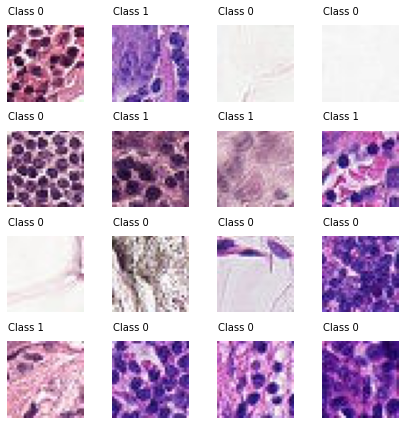

In [4]:
# view sample data
sample = train.sample(n=16).reset_index()
plt.figure(figsize=(6,6)) # specifying the overall grid size

for i, row in sample.iterrows():  
    # a (32, 32, 3) image shape
    img = mpimg.imread(f'{train_dir}{row.id}')
    label = row.label
    
    plt.subplot(4,4,i+1)    # the number of images in the grid is 6*6 (16)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [5]:
# display the count of the two classes
print('1 classes: ', len(train[train['label'] == 1]))
print('0 classes: ', len(train[train['label'] == 0]))

# so the data is biased to the 0 class
# make a balance between these two classes
sample_size = 10000

train_0 = train[train['label'] == 0].sample(sample_size, random_state=1)
train_1 = train[train['label'] == 1].sample(sample_size, random_state=1)

# now lets merge the two classes again into the same training set
train_set = pd.concat([train_0, train_1], axis=0).reset_index(drop=True)

# shuffle the data
train = shuffle(train_set)

train['label'].value_counts()

1 classes:  89117
0 classes:  130908


0    10000
1    10000
Name: label, dtype: int64

In [14]:
def convert_df_to_row(dataFrame, image_name, label):
    ''' The purpose of this function is to calculate the mean of each feature row'''
    
    # calculate the mean for each col
    temp_df = dataFrame.mean().to_frame().T
    
    # add the image name and label
    temp_df.insert(loc=0, column='image_name', value=image_name)
    temp_df.insert(loc=temp_df.shape[1], column='label', value=label)
    
    
    return temp_df

# Feature Extraction
Here we will perform feature extraction using CV filters such as Gabor filters, Gaussian filters, and Entropy filters. And keep performing this operatoin for each image in the training set, and appending the current image's extracted features to the data set DataFrame object (via calculating the mean for each feature column of each image)

In [15]:
# data frame to hold all features for all images
train_set_df = pd.DataFrame()
single_image_df = pd.DataFrame()

# iterate over each image in train
index = 0
for idx, image, label in train.itertuples():
    
    # temp data frame to capture features for the current image
    current_image_df = pd.DataFrame()
    
    # read the image train dir
    image_arr = cv2.imread(train_dir + image)
    # chech if the image is on the gray scale otherwise covert it to grayscale
    if image_arr.ndim == 3 and image_arr.shape[-1] == 3:   # this is an rgb colored image
        gray_image = cv2.cvtColor(image_arr, cv2.COLOR_BGR2GRAY)
    elif image_arr.ndim == 2:
        # its aleardy a gray image
        gray_image = image_arr
    else:
        raise Exceptoin(f'{image} is not supported')
    
    # add the images pixel values to the data frame as its a feature
    current_image_df['pixel_value'] = gray_image.reshape(-1)
    
    #### now apply gabor filter to generate features
    kernels = []
    num = 1
    for thetah in range(2):
        thetah = thetah / 4. * np.pi
        for sigma in range(1, 3):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.5): 

                    # naming the features which will be on columns
                    gabor_label = gabor_label = 'gabor' + str(num)

                    kernel_size = 9
                    kernel = cv2.getGaborKernel(
                        (kernel_size, kernel_size),
                        sigma,
                        thetah,
                        lamda,
                        gamma,
                        0,
                        ktype=cv2.CV_32F
                    )
                    # append this kernel
                    kernels.append(kernel)
                    
                    # now apply the filter on the gray_image
                    filtered_image = cv2.filter2D(gray_image, cv2.CV_8UC3, kernel)
                    
                    # append to the current image dataframe
                    current_image_df[gabor_label] = filtered_image.reshape(-1)
                    
                    num += 1
                    
                    # done with gabor filter
    
    # lets apply another filters to the gray image to get more features
    # CANNY EDGE
    edges = cv2.Canny(gray_image, 100, 200)
    current_image_df['canny_edges'] = edges.reshape(-1)
    
    # ROBERTS EDGE
    edge_roberts = roberts(gray_image)
    current_image_df['Roberts'] = edge_roberts.reshape(-1)

    #SOBEL
    edge_sobel = sobel(gray_image)
    current_image_df['Sobel'] = edge_sobel.reshape(-1)

    #SCHARR
    edge_scharr = scharr(gray_image)
    current_image_df['Scharr'] = edge_scharr.reshape(-1)
    
    # GUSSIAN with sigma=3
    gaussian_img = nd.gaussian_filter(gray_image, sigma=3)
    current_image_df['Gaussian s3'] = gaussian_img.reshape(-1)

    #GAUSSIAN with sigma=7
    gaussian_img2 = nd.gaussian_filter(gray_image, sigma=7)
    current_image_df['Gaussian s7'] = gaussian_img2.reshape(-1)

    #MEDIAN with sigma=3
    median_img = nd.median_filter(gray_image, size=3)
    current_image_df['Median s3'] = median_img.reshape(-1)

    #VARIANCE with size=3
    variance_img = nd.generic_filter(gray_image, np.var, size=3)
    current_image_df['Variance s3'] = variance_img.reshape(-1) 
    
    index += 1
    # capture the image data frame of the 10th image
    if index == 10:
        single_image_df = current_image_df.copy(deep=True)
    
    current_image_row = convert_df_to_row(current_image_df, image[: image.find('.tif')], label)
    
    # append the current image df to the whole data set df
    train_set_df = train_set_df.append(current_image_row)
    
    
    
train_set_df.set_index('image_name', inplace=True)

# write the images features to a new csv
single_image_df.to_csv('single_image_df.csv')
train_set_df.to_csv('full_trainset-v1-1.csv')

# Droping Falsy Features and plot histograms for each feature

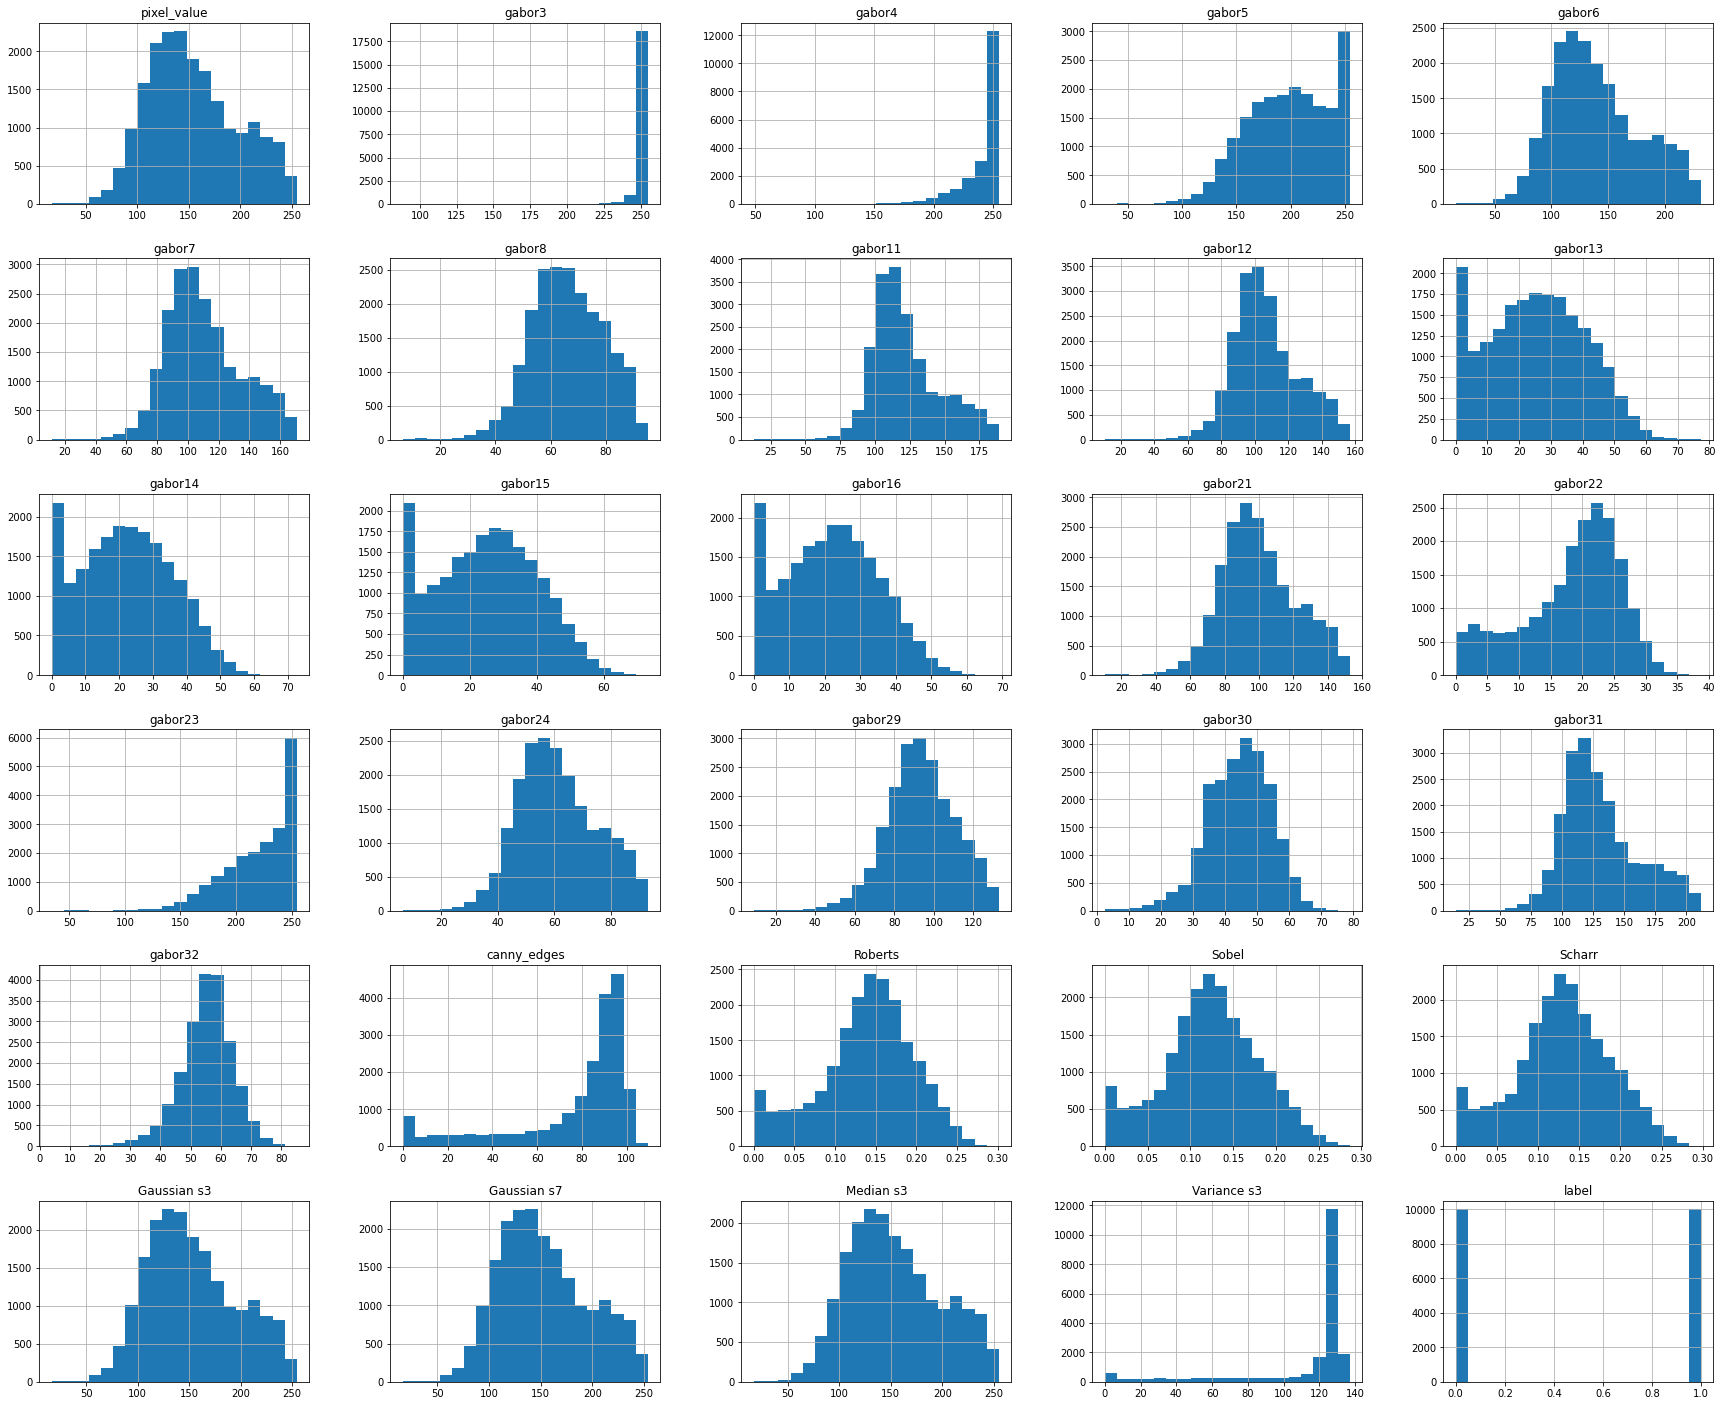

In [6]:
train = pd.read_csv('full_trainset-v1-1.csv')

# drop incorrelated data
train.drop(['image_name', 'gabor1','gabor2','gabor9','gabor10','gabor17','gabor18','gabor19','gabor20','gabor25','gabor26','gabor27','gabor28'], inplace = True, axis = 1) 

train.hist(bins=20, figsize=(30,25))
plt.show()

# Splitting the data

In [7]:
# now lets make the training set and hold out a validation set
X = train.iloc[: , 1:-1].values
y = train.iloc[: , -1].values


# Dimensioniality Reduction
here we will reduece the number of dimensions of the dataset to acheive a faster training for the data and gain a more insight into the dataset for visualization

* ##  For Visualizatoin

In [11]:
from sklearn.decomposition import PCA

pca_vis = PCA(n_components=3)   # reducing the demisions of the dataset into 3D for better visualization
X_3D = pca_vis.fit_transform(X)

array([[ -35.24265578,   23.40063894,  -36.48701779],
       [ -84.46088633,  -13.68023915,   -4.04492605],
       [-208.19864413,   43.54801449,   13.25622697]])

* ## For Faster Training

In [23]:
pca_d = PCA(n_components=5)  # reducing the deminsions to a number of diminsions that sum preserve the vaiance between data so the variance should sum up to 0.95
X_reduced = pca_d.fit_transform(X)
X_reduced.shape

(20000, 5)

# Training the models

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


X_train, X_test, y_train, y_test = train_test_split(
    
    X, y.reshape(-1,1) , test_size=0.10, random_state=1
)

# linear classifiers
model = None
guss_clf = GaussianNB()                             # 72%
knn_clf = KNeighborsClassifier()                   # 70%
sgd_clf = SGDClassifier(random_state=42)           # 72%
pre_clf = Perceptron()                             # 78%
dt_clf = DecisionTreeClassifier()                 # 62%
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42, max_leaf_nodes=16, n_jobs=-1)        # 85%
log_clf = LogisticRegression()
svm_clf = svm.LinearSVC()

# polynomial support vector machine classifier with 3 degrees
svm_poly_clf = svm.SVC(kernel='poly', degree=2, coef0=1, C=5)
svm_rbf_clf = svm.SVC(kernel='rbf', gamma=5, C=0.001)

# using an ensemble
ensemble_model = VotingClassifier(
    estimators=[('svc', svm_poly_clf),
                ('lr', log_clf),
                ('rf', rnd_clf),
                ('per', pre_clf)],                 # the ensemble got 80% of accurecy
    voting='hard'
)

# pipe = make_pipeline(scaler, svm_clf)            # apply the model here

# # fit the model
model = rnd_clf
model.fit(X_train, y_train.reshape(-1))
# print('accurecy: ', pipe.score(X_test, y_test) * 100, '%')
predictions = model.predict(X_test)


# Compute how well we performed
correct = (y_test.reshape(-1) == predictions).sum()
incorrect = (y_test.reshape(-1) != predictions).sum()
total = len(predictions)

# Print results
print(f"Results for model {type(model).__name__}")
print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")
print(f"Accuracy: {100 * correct / total:.2f}%")

Results for model RandomForestClassifier
Correct: 1554
Incorrect: 446
Accuracy: 77.70%


# Feature Importances incase of Random forest
this shows how much the image extracted features contribute to the decision when using a random forest classifier

In [38]:
for fet, score in zip(train.columns, model.feature_importances_):
    print(fet, ':', score)

pixel_value : 0.02699109285146186
gabor3 : 0.04161386283631193
gabor4 : 0.03388627279391725
gabor5 : 0.03625538458617284
gabor6 : 0.04680961138333658
gabor7 : 0.006386757159154631
gabor8 : 0.049171566565549864
gabor11 : 0.037022601991758684
gabor12 : 0.045622804240873456
gabor13 : 0.0322346355912545
gabor14 : 0.01575596218254248
gabor15 : 0.015673502937758033
gabor16 : 0.017723451524212473
gabor21 : 0.005247340225892678
gabor22 : 0.03236730684580097
gabor23 : 0.031685261547302467
gabor24 : 0.0035605660961234974
gabor29 : 0.0032824741637073
gabor30 : 0.06847394129909574
gabor31 : 0.0062291042196712795
gabor32 : 0.010353793380528513
canny_edges : 0.07971878725733829
Roberts : 0.12919729625110649
Sobel : 0.1151697778582783
Scharr : 0.02622821027178527
Gaussian s3 : 0.02768811224150227
Gaussian s7 : 0.02426164806452847
Median s3 : 0.03138887363303395


# Training vs Validation curves

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
plot_learning_curves(model, X, y)
        
plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

KeyboardInterrupt: 

# Measures of Perfomance
* ## Precision and Recall curve

In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

y_scores1 = cross_val_predict(model, X_train, y_train.reshape(-1), cv=3)

# print the precision and recall scores for this model
print('precision: ', precision_score(y_train, y_scores1))
print('recall: ', recall_score(y_train, y_scores1))

precision:  0.7700966458214895
recall:  0.7528901734104047


* ## Confusion matrix

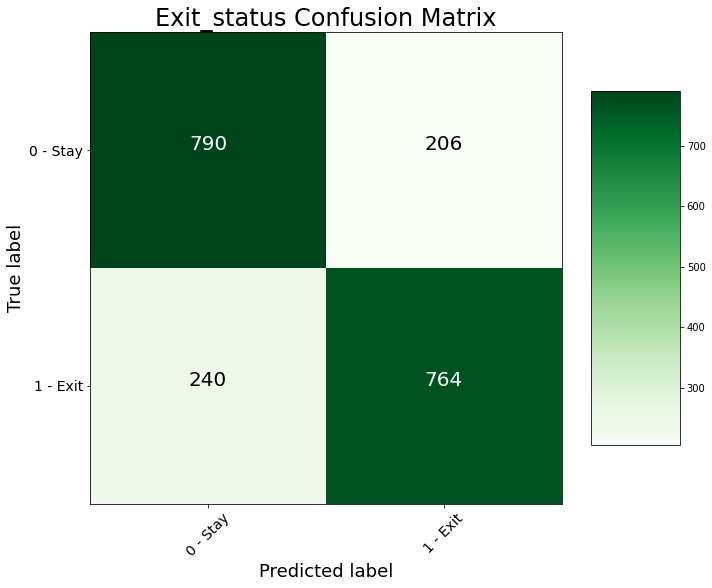

In [51]:
import itertools

def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

# Let's plot it out
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0 - Stay', '1 - Exit'],
                      title = 'Exit_status Confusion Matrix')

* ## ROC AUC scores

In [40]:
train_probs = model.predict_proba(X_train)[:,1] 
probs = model.predict_proba(X_test)[:, 1]
train_predictions = model.predict(X_train)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.8402791351168661
Test ROC AUC  Score: 0.8403709459351348


* ## ROC Curve

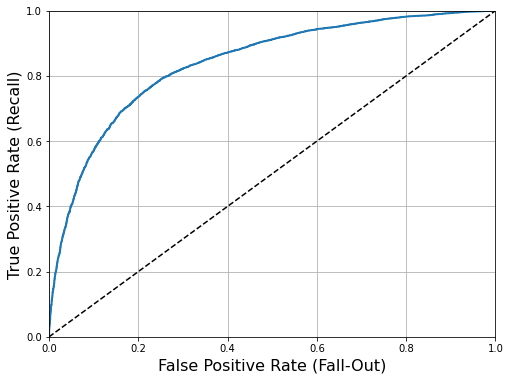

In [43]:
fpr, tpr, thresholds = roc_curve(y_train, train_probs)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)          
plt.show()